In [10]:
# The following code is a simple modification of the moment of inertia \n
# model with contiguity as described by Dr. Austin Buchanan, \n
# which can be found here: https://bit.ly/3NMgfQE 

######### START DEPENDENCIES #########

#gerrychain for parsing JSON files 
from gerrychain import Graph
#geopy for retrieving geodata on county names
from geopy.distance import geodesic
#gurobi/networkx for IP purposes
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
#geopandas to make our fun little map at the end :)
import geopandas as gpd
#for rounding functions relating to population bounds
import math

######### END DEPENDENCIES ###########

#Parse population/county data with gerrychain
filepath = 'pop_data\\'
filename = 'NE_county.json'

#Instantiating graph, gerrychain style (not with NetworkX)
G = Graph.from_json( filepath + filename )

#adding graph vertices (nodes)
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001'] # population of county
    G.nodes[node]['C_X'] = G.nodes[node]['INTPTLON20']  # longitude of county's center
    G.nodes[node]['C_Y'] = G.nodes[node]['INTPTLAT20']  # latitude of county's center

# create distance dictionary
dist = { (i,j) : 0 for i in G.nodes for j in G.nodes }
for i in G.nodes:
    for j in G.nodes:
        loc_i = ( G.nodes[i]['C_Y'], G.nodes[i]['C_X'] )
        loc_j = ( G.nodes[j]['C_Y'], G.nodes[j]['C_X'] )
        dist[i,j] = geodesic(loc_i,loc_j).miles

#2% population deviation (+/-1%) used in this model
deviation = 0.02

#Nebraska has 3 districts therefore k = 3
k = 3
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes)
dev_val = total_population * deviation
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("The deviation value is ", dev_val ,"Using Lower bound L =",L,", Upper bound U =",U,", and number of districts k =",k)


The deviation value is  39230.08 Using Lower bound L = 647297 , Upper bound U = 660373 , and number of districts k = 3


In [7]:
# create model 
m = gp.Model()

#x[i,j] is a binary variable for county i and district* j \n
#*j is actually a county but is representative of the district that
# it is the center of.

#x is 1 when the county is assigned to a district
x = m.addVars( G.nodes, G.nodes, vtype=GRB.BINARY )

m.setObjective( gp.quicksum( dist[i,j] * dist[i,j] * G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes for j in G.nodes ), GRB.MINIMIZE )
#Each county i is only assigned to one district j
m.addConstrs( gp.quicksum( x[i,j] for j in G.nodes ) == 1 for i in G.nodes )

#there are k centers representing k districts
m.addConstr( gp.quicksum( x[j,j] for j in G.nodes ) == k )

#if j is the center of a district, its population is between the lower and upper population bounds.
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) >= L * x[j,j] for j in G.nodes )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes ) <= U * x[j,j] for j in G.nodes )

#if i is assigned to j, then j is a center.
m.addConstrs( x[i,j] <= x[j,j] for i in G.nodes for j in G.nodes )

m.update()

In [8]:
# This is where we impose contiguity constraints on the model
DG = nx.DiGraph(G)

# add flow variables. What are flow variables you ask? read the above paper or
# our final report to better understand.

# f[i,j,v] = flow across arc (i,j) that is sent from source/root v
f = m.addVars(DG.edges, G.nodes) 

# if node i is assigned to node j, 
# then node i must consume one unit of node j's flow
m.addConstrs( gp.quicksum( f[u,i,j] - f[i,u,j] for u in G.neighbors(i) ) == x[i,j] for i in G.nodes for j in G.nodes if i != j )

# node i can receive flow of type j iff node i is assigned to node j
M = G.number_of_nodes() - 1
m.addConstrs( gp.quicksum( f[u,i,j] for u in G.neighbors(i) ) <= M * x[i,j] for i in G.nodes for j in G.nodes if i != j )

# node j cannot receive flow of its own type (cannot use up its own supply)
m.addConstrs( gp.quicksum( f[u,j,j] for u in G.neighbors(j) ) == 0 for j in G.nodes )

#there are no gaps in between districts
#(each county is assigned and all districts directly border each other. No Switzerlands)
m.Params.MIPGap = 0.0

m.optimize()

# retrieve the districts and their populations
#    but first get the district "centers"

centers = [ j for j in G.nodes if x[j,j].x > 0.5 ]

districts = [ [ i for i in G.nodes if x[i,j].x > 0.5 ] for j in centers ]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")


Set parameter MIPGap to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 26134 rows, 51615 columns and 188238 nonzeros
Model fingerprint: 0x3d2cb812
Variable types: 42966 continuous, 8649 integer (8649 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+05, 9e+10]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 292 rows and 663 columns
Presolve time: 0.62s
Presolved: 25842 rows, 50952 columns, 186735 nonzeros
Variable types: 42308 continuous, 8644 integer (8644 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simpl

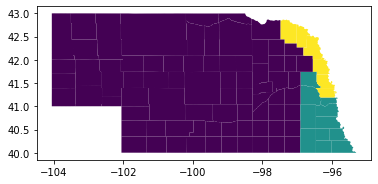

In [9]:
######### MAP CONSTRUCTION #########
filepath = 'pop_data\\'
filename = 'NE_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : -1 for i in G.nodes }
for j in range(k):
    district = districts[j]
    for i in district:
        labeling[i] = j

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()